# Surface Code
Notebook for playing around and building a surface code using Qiskit. We begin by following [An introduction to the surface code, Andrew N. Cleland](https://scipost.org/SciPostPhysLectNotes.49/pdf). 

### Simple Examples
Let's first create the quantum circuit for one surface code cycle for a measure-Z qubit, forcing data qubits into an eigenstate of (stabilizes) $Z_0Z_1Z_2Z_3$ and for a measure-X qubit, which stabilizes $X_0X_1X_2X_3$ (i.e. figure 20 from the paper).

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile
from qiskit.quantum_info import Statevector
import numpy as np

#Declare backend we will use throughout
simulator = Aer.get_backend('aer_simulator')

# Create a Quantum Register with 5 qubits (4 data qubits and 1 ancilla qubit for stabilzer +measurement)
qreg = QuantumRegister(5, 'q')

# Create a Classical Register with 1 bit
creg = ClassicalRegister(1, 'c')

# Create an Z measure Quantum Circuit 
Zcircuit = QuantumCircuit(qreg, creg)

# Entangle the data qubits with the ancilla qubit
for i in range(1,5):
    Zcircuit.cx(qreg[i], qreg[0])  # Apply CX gate between data qubit and ancilla

# Measure the ancilla qubit and store the result in the classical bit
Zcircuit.measure(qreg[0], creg[0])

Zcircuit.draw()

┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: ┤ X ├┤ X ├┤ X ├┤ X ├┤M├
     └─┬─┘└─┬─┘└─┬─┘└─┬─┘└╥┘
q_1: ──■────┼────┼────┼───╫─
            │    │    │   ║ 
q_2: ───────■────┼────┼───╫─
                 │    │   ║ 
q_3: ────────────■────┼───╫─
                      │   ║ 
q_4: ─────────────────■───╫─
                          ║ 
c: 1/═════════════════════╩═
                          0

Once we make projective measurement of the measure qubits e.g. for $Z$ measure qubit, the state will
be $$Z_{0123}|\psi\rangle$$ ($Z_{0123} = \pm 1$). This state is the quiescent state. When we extend to a full array, starting with the very first complete measurement cycle when starting up a surface code, the $Z$ measure and $X$ measure take whatever initial state the data qubits are in, and project from that state a complex entangled state $|\psi\rangle$ that is a simultaneous eigenstate of all the measurements across the array. Once selected, in the absence of errors, the same state $|\psi\rangle$ will be maintained by each
subsequent cycle of the sequence, with each measure qubit yielding the same measurement
outcome as it measured in the previous cycle (due to the stabilizer measurements commuting). Let's illustrate this by first just considering the $Z$ measure circuit.

In [4]:
num_cycles = 5

# Create a Quantum Register with 5 qubits (4 data qubits and 1 ancilla qubit for stabilizer + measurement)
qreg = QuantumRegister(5, 'q')
# Create a Classical Register with a bit for each cycle
creg = ClassicalRegister(num_cycles, 'c')
# Create a Quantum Circuit for each cycle
Zcircuit = QuantumCircuit(qreg, creg)

# Create an arbitrary initial state for data qubits (we choose 1/sqrt{2}(|0000> + |0111>) for illustration)
Zcircuit.h(1)
Zcircuit.cx(1,2)
Zcircuit.cx(2,3)

for cycle in range(num_cycles):
    # Reset the ancilla qubit to the |0> state
    Zcircuit.reset(qreg[0])

    # Entangle the data qubits with the ancilla qubit
    for i in range(1, 5):
        Zcircuit.cx(qreg[i], qreg[0])

    # Seeing the state of our initial circuit for visualization
    if cycle == 0:
        state_simulator = Aer.get_backend('statevector_simulator')
        job = execute(Zcircuit, state_simulator)
        state_vector = job.result().get_statevector()

    # Measure the ancilla qubit and store the result in the classical register
    Zcircuit.measure(qreg[0], creg[cycle])

# Execute the circuit
job = execute(Zcircuit, simulator, shots=1)
result = job.result().get_counts()

# Print pre-measurement state
print("Pre Measurement State: ", np.asarray(state_vector).real, "\n")

# Extract and print the measurement result for each cycle
measurement_results = list(result.keys())[0]  # Assuming a single shot, so only one key
for cycle in range(num_cycles):
    # In Qiskit, the bits are in reverse order
    cycle_measurement = measurement_results[-1-cycle]
    print(f"Cycle {cycle} Measurement: {cycle_measurement}")


Pre Measurement State:  [0.70710678 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.70710678 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] 

Cycle 0 Measurement: 0
Cycle 1 Measurement: 0
Cycle 2 Measurement: 0
Cycle 3 Measurement: 0
Cycle 4 Measurement: 0


Here we can see an illustration of this. The initial state is $$\frac{1}{\sqrt{2}} (|0000\rangle + |0111\rangle)\otimes |0\rangle$$. Then, after the cycle (pre-measurement), the ancilla becomes entangled with the data qubits and the state is $1/\sqrt{2} (|00000\rangle + |01111\rangle)$. Now we can clearly see that a measurement of 0 or 1 of the ancilla will causes the state to collapse to a +1 ($|0000\rangle$) or -1 ($|0111\rangle$)  eigenstate of the $Z_0 Z_1 Z_2 Z_3$ stabilizer respectively. This collpased state is the quiescent state, and we can see from the other ancilla qubit measurements that this state remains throughout the following cycles (provided there's no errors!). We can now see this is the case for the $X$-measure qubit too.

In [5]:
num_cycles = 3

# Create a Quantum Register with 5 qubits (4 data qubits and 1 ancilla qubit for stabilizer + measurement)
qreg = QuantumRegister(5, 'q')
# Create a Classical Register with a bit for each cycle
creg = ClassicalRegister(num_cycles, 'c')
# Create a Quantum Circuit for each cycle
Xcircuit = QuantumCircuit(qreg, creg)

# Initialize data qubits to |0000>
# No additional gates needed as qubits are initialized to |0> by default

for cycle in range(num_cycles):
    # Reset the ancilla qubit to the |0> state
    Xcircuit.reset(qreg[0])

    #Change ancilla basis
    Xcircuit.h(qreg[0])

    # Entangle the data qubits with the ancilla qubit (now ancilla is the control)
    for i in range(1, 5):
        Xcircuit.cx(qreg[0], qreg[i])


    #Change the ancilla basis
    Xcircuit.h(qreg[0])
    
    # Seeing the state of our initial circuit for visualization
    if cycle == 0:
        state_simulator = Aer.get_backend('statevector_simulator')
        job = execute(Xcircuit, state_simulator)
        state_vector = job.result().get_statevector()

    # Measure the ancilla qubit and store the result in the classical register
    Xcircuit.measure(qreg[0], creg[cycle])

# Execute the circuit
simulator = Aer.get_backend('aer_simulator')
job = execute(Xcircuit, simulator, shots=1)
result = job.result().get_counts()

# Print pre-measurement state
print("Pre Measurement State: ", np.asarray(state_vector).real, "\n")

# Extract and print the measurement result for each cycle
measurement_results = list(result.keys())[0]  # Assuming a single shot, so only one key
for cycle in range(num_cycles):
    # In Qiskit, the bits are in reverse order
    cycle_measurement = measurement_results[-1-cycle]
    print(f"Cycle {cycle} Measurement: {cycle_measurement}")


Pre Measurement State:  [ 0.5  0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.5 -0.5] 

Cycle 0 Measurement: 0
Cycle 1 Measurement: 0
Cycle 2 Measurement: 0


We also see the same thing here. The initial state of the data qubits is $|0000\rangle$, then the entanglement with the ancilla projects the state to 
$$
\large |\psi\rangle = \frac{1}{2}\left((|0000\rangle + |1111\rangle) \otimes |0\rangle + (|0000\rangle - |1111\rangle) \otimes |1\rangle)\right).
$$
So then measurement of the $X$-type ancilla leaves the system in one of two possible eigenstates of $X_1X_2X_3X_4$, with the ancilla measurement indicating which: 0 (1) for +1 (-1) eigenvalue.

### 7 qubit Error Detection Surface Code
The smallest possible surface code (working from [Repeated Quantum Error Detection in a Surface Code](https://arxiv.org/pdf/1912.09410.pdf)) has 7 qubits, 4 data qubits ($D_1, D_2, D_3, D_4$), 2 $Z$ ancillas ($Z_1Z_2$) and 1 $X$ ancilla ($X_1$).

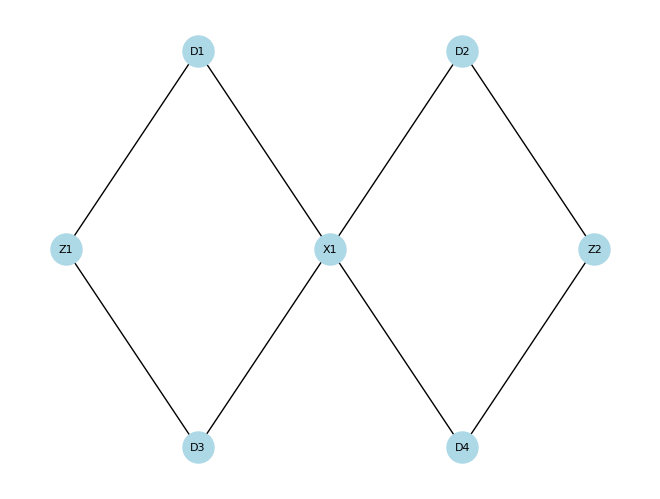

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a new graph
G = nx.Graph()

# Add nodes with positions
positions = {'D1': (0, 1), 'D2': (2, 1), 'D3': (0, -1), 'D4': (2, -1),
             'Z1': (-1, 0), 'X1': (1, 0), 'Z2': (3,0 )}

for node, pos in positions.items():
    G.add_node(node, pos=pos)

# Add edges between nodes
edges = [('D1', 'Z1'), ('D1', 'X1'), ('D2', 'X1'), ('D2', 'Z2'), 
         ('D3', 'Z1'), ('D3', 'X1'), ('D4', 'X1'), ('D4', 'Z2')]

G.add_edges_from(edges)

# Draw the graph
nx.draw(G, positions, with_labels=True, node_size=500, node_color='lightblue', font_size=8)
plt.show()


Let's try to build the circuit, using what we know from above and the Cleland paper. Qubit 4 will be the X ancilla, qubits 5 (z1) and 6 (z2) will be the z ancillas. The codewords are
$$
|0\rangle_L = \frac{1}{\sqrt{2}}(|0000\rangle + |1111\rangle), \quad |1\rangle_L = \frac{1}{\sqrt{2}}(|1010\rangle + |0101\rangle)
$$

and the stabilizers are
$$
X_1 X_2 X_3 X_4, \quad Z_1Z_3, \quad Z_2 Z_4
$$

So we can detect single phase flip errors from the $X$ stabilizer measurement $$X_1X_2X_3X_4\left(Z_\mu|\psi\rangle\right) = -Z_\mu\left(X_1X_2X_3X_4|\psi\rangle\right)\\
= -X_{1234}\left(Z_\mu|\psi\rangle\right)$$
and up to 2 bit flips (provided they are on qubits connected to different $Z$ stabilizers), e.g.
$$
Z_1Z_3\left(X_1 |\psi\rangle\right) = -Z_{13}\left(X_1 |\psi\rangle\right)
$$
and 
$$
Z_2Z_4\left(X_3 |\psi\rangle\right) = -Z_{24}\left(X_3|\psi\rangle\right)
$$

State:  [ 0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.5  0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0. ] 
 Result:  {'001': 481, '000': 519}


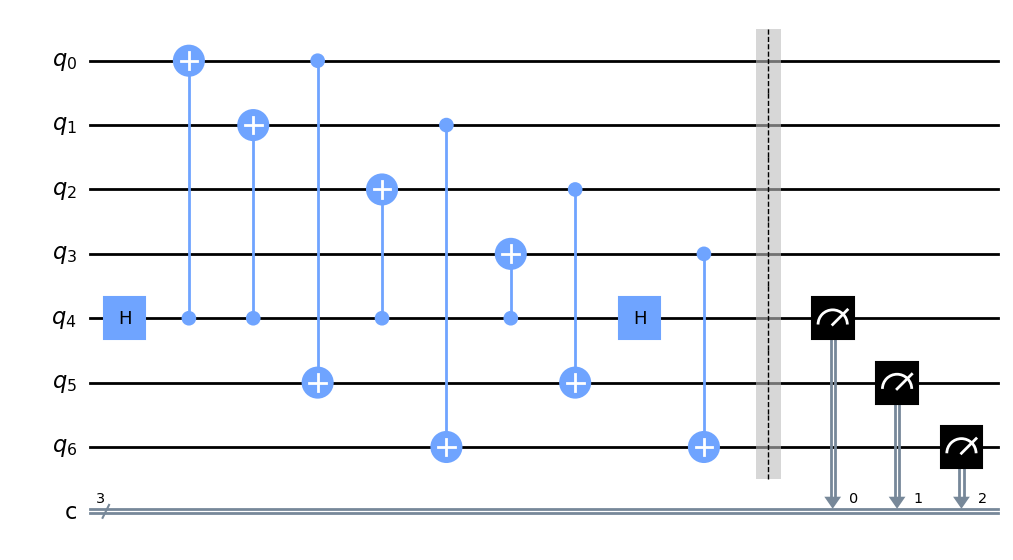

In [7]:
# Create a Quantum Register with 7 qubits (4 data qubits and 3 ancilla qubits for stabilizer + measurement)
qreg = QuantumRegister(7, 'q')

# Create a Classical Register
creg = ClassicalRegister(3, 'c')

# Create a Quantum Circuit for each cycle
sevenq_sc = QuantumCircuit(qreg, creg)

# Entangle with X ancilla (same as above)
sevenq_sc.h(qreg[4])

for i in range (0,4):
    sevenq_sc.cx(qreg[4], qreg[i]) #Remembering X type is control
    
sevenq_sc.h(qreg[4])

#Entangle with Z_1
sevenq_sc.cx(qreg[0], qreg[5])
sevenq_sc.cx(qreg[2], qreg[5])

#entangle with Z_2
sevenq_sc.cx(qreg[1], qreg[6])
sevenq_sc.cx(qreg[3], qreg[6])

sevenq_sc.barrier()

#Check the pre-measurement state
state_simulator = Aer.get_backend('statevector_simulator')
job = execute(sevenq_sc, state_simulator)
state_vector = job.result().get_statevector()

#Measure ancillas
for i in range(0, 3):
        sevenq_sc.measure(qreg[i+4], creg[i])

# Execute the circuit
job = execute(sevenq_sc, simulator, shots=1000)
result = job.result().get_counts()

print("State: ", np.asarray(state_vector).real, "\n Result: ", result)
sevenq_sc.draw('mpl')

We can see that we will be in our desired quiescent state when the ancillas are measured to all be $|000\rangle$ (which happens half the time). So let's now create a function to see how well the 7 qubit error detection surface code detects errors. Instead of running the circuit with all qubits starting in the $|0\rangle$ state, we'll just assume that the quiescent state is $|0\rangle_L$, as defined above. We currently just implement for Pauli errors.

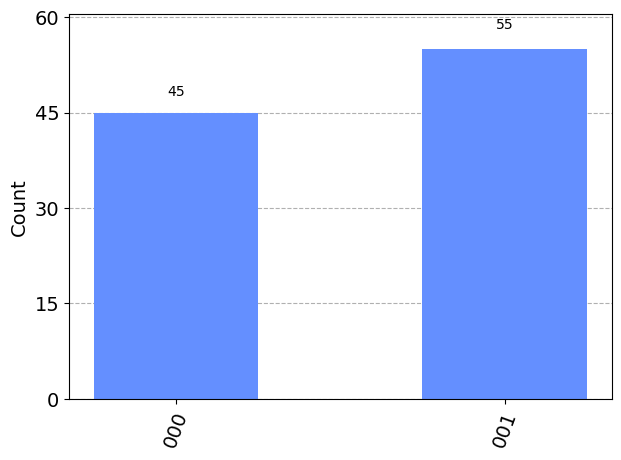

In [8]:
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import pauli_error

def simulate_surface7(circuit, num_cycles):
    """
    Simulates the 7-qubit surface code for a given number of cycles.

    Parameters:
    num_cycles (int): The number of error correction cycles to simulate.
    p_pauli (float, optional): The probability of a Pauli error (X or Z) occurring. Defaults to 0.0.

    The circuit performs the following steps for each cycle:
    - Applies Pauli errors based on the error model.
    - Resets ancilla qubits.
    - Entangles qubits to perform error correction.
    - Measures the state of ancilla qubits.
    
    Returns:
    dict: A dictionary of measurement outcomes with their corresponding counts.
    """
    # Define Pauli error model
    for cycle in range(num_cycles):

        # Reset ancillas
        for i in range(4, 7):
            circuit.reset(qreg[i])

        # Entangle with X ancilla
        circuit.h(qreg[4])
        for i in range(4):
            circuit.cx(qreg[4], qreg[i])  # X type is control
        circuit.h(qreg[4])

        # Entangle with Z_1
        circuit.cx(qreg[0], qreg[5])
        circuit.cx(qreg[2], qreg[5])

        # Entangle with Z_2
        circuit.cx(qreg[1], qreg[6])
        circuit.cx(qreg[3], qreg[6])

        # Measure ancillas
        for i in range(3):
            circuit.measure(qreg[i + 4], creg[cycle * 3 + i])


        circuit.barrier()

num_cycles = 1
# Initialize registers and circuit
qreg = QuantumRegister(7, 'q')
creg = ClassicalRegister(num_cycles * 3, 'c')
circuit = QuantumCircuit(qreg, creg)

simulate_surface7(circuit, num_cycles)
# Execute the circuit and get the result
simulator = Aer.get_backend('aer_simulator')
job = execute(circuit, simulator, shots=100)
result = job.result().get_counts()


# Plot the histogram
plot_histogram(result)

Here we see the codes ability to detect errors. 

### Noise model implementation
In order to reproduce some results from the paper, let's create a noise model, using qiskits own noise models. So we see the state will collapse to any one of the eigenstates of the stabilizers. Then, in the abscence of errors, this state will remain throughout all cycles, and the ancilla measurements will be the same. With the presence of errors, the error will causes a unique change in the ancilla readout/syndrome measurement.

In [9]:
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit_aer import AerSimulator

# Define the probability of SPAM errors
spam_probs = 0.01
spam_error = pauli_error([('X', spam_probs), ('I', 1 - spam_probs)])

#----------------------------------------------------------------------------------------

# Probability of depolarizing error
p_depol = 0.01
# Create depolarizing error for a single qubit gate
depol_error = depolarizing_error(p_depol, 1)
two_qubit_depol_error = depol_error.tensor(depol_error)

#----------------------------------------------------------------------------------------

# Define T1 and T2 times (in micro seconds) for thermal relaxation error, taken from qiskit docs
t1 = 50e3 # T1 relaxation time
t2 = 70e3 # T2 dephasing time

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
# time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# Create thermal relaxation error for cx
cx_error = thermal_relaxation_error(t1, t2, time_cx).tensor(thermal_relaxation_error(t1, t2, time_cx))

#----------------------------------------------------------------------------------------

Full_Noise_Model = NoiseModel()

# Apply error to measurements and reset
Full_Noise_Model.add_all_qubit_quantum_error(spam_error, "measure")  
Full_Noise_Model.add_all_qubit_quantum_error(spam_error, "reset")

# Create and add thermal relaxation error for u1, u2 , u3, cx and measurement
Full_Noise_Model.add_all_qubit_quantum_error(thermal_relaxation_error(t1, t2, time_u1), ['u1'])
Full_Noise_Model.add_all_qubit_quantum_error(thermal_relaxation_error(t1, t2, time_u2), ['u2'])
Full_Noise_Model.add_all_qubit_quantum_error(thermal_relaxation_error(t1, t2, time_u3), ['u3'])
Full_Noise_Model.add_all_qubit_quantum_error(cx_error, ['cx'])
Full_Noise_Model.add_all_qubit_quantum_error(thermal_relaxation_error(t1, t2, time_measure), "measure")  # Apply error to measurements

#Apply Depolarization errors
Full_Noise_Model.add_all_qubit_quantum_error(depol_error, ['u1', 'u2', 'u3'])
Full_Noise_Model.add_all_qubit_quantum_error(two_qubit_depol_error, ["cx"])

#----------------------------------------------------------------------------------------

Full_Simulator = AerSimulator(noise_model=Full_Noise_Model)

# print(Full_Noise_Model)

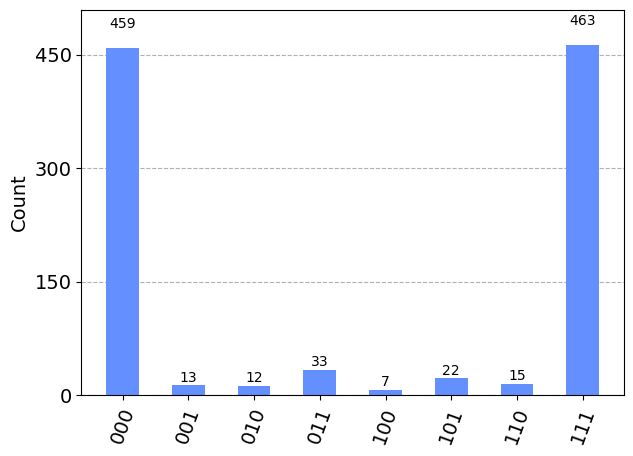

In [10]:
#----------------------------------------------------------------------------------------

#Example GHZ state
example = QuantumCircuit(3)
example.h(0)
example.cx(0,1)
example.cx(0,2)

example.measure_all()

# Transpile the circuit for the full noise model
example_tnoise = transpile(example, Full_Simulator)

# Run and get counts
example_result = Full_Simulator.run(example_tnoise).result()
example_counts = example_result.get_counts(0)

# Plot noisy output
plot_histogram(example_counts)


# Plotting & Anaylsis
We first consider FIG.5 a), which involves calculating logical operators expectation values after $1- 10$ cycles. We will first calculate the expectation value of the logical operator: 
$$
Z_L = Z_{D1} Z_{D2}
$$
This is equivalent to measuring the $T_1$ times for $|0\rangle_L$ and $|1\rangle_L$, as $\langle0|_L Z_L | 0 \rangle$ goes to 0 as physical $|1\rangle$ decays to physical $|0\rangle$. To first do this, we will create function(s) to calculate the expectation value of $Z_L$ given the results of a qiskit measurement of the 4 data qubits.

In [11]:
from qiskit.quantum_info import SparsePauliOp, Pauli

def logical_z_expectation_statevector(statevector):
    # Create logical Z using SparsePauliOp
    Z = SparsePauliOp(Pauli('Z'))
    I = SparsePauliOp(Pauli('I'))
    Z_L = Z.tensor(Z).tensor(I).tensor(I)
    Z_L = np.real(Z_L.to_matrix())
    
    #Calculate expecation value
    exp_value = statevector.T.conj() @ Z_L @ statevector

    return exp_value



def logical_z_expectation(counts_noise):
    """
    Calculate the logical Z expectation value from a counts dictionary.

    Parameters:
    counts_noise: Dictionary of counts from the quantum circuit execution.

    Returns:
    The calculated expectation value.
    """
    expectation_value = 0
    total_shots = sum(counts_noise.values())

    for key, value in counts_noise.items():
        # Slice the first 4 bits (the data qubits)
        sliced_key = key[:4]

        # Convert the sliced bit string to an integer index
        idx = int(sliced_key, 2)

        # Initialize a state vector of size 2^4 for our data qubits
        state_vector = np.zeros(2**4)

        # Set the value at the index to 1
        state_vector[idx] = 1

        # Calculate the expectation value for the given outcome
        outcome_exp_value = logical_z_expectation_statevector(state_vector)
        
        # Accumulate the weighted expectation value
        expectation_value += outcome_exp_value * value

    # Normalize by the total number of shots
    expectation_value /= total_shots if total_shots > 0 else 1

    return expectation_value.real


#Example Usage

# Define logical 1
state = np.zeros(16) 
state[5] = 1/np.sqrt(2)  # Set the amplitude for |0101>
state[10] = 1/np.sqrt(2)  # Set the amplitude for |1010>  

exp_value = logical_z_expectation_statevector(state)

print("<1|_L Z_L |1>_L = ", exp_value.round())

<1|_L Z_L |1>_L =  -1.0


Fig 5)a) also only considers runs where no errors have been detected after the $N$ stabilizer measurement cycles (i.e. for the 5th cycle, we'll calculate the expectation value for shots where all three ancillas have given syndrome measurements of 0). To do this, we create a function to remove any measurement results where errors have been detected. Quote "We do so by repeatedly measuring the expectation value
of the encoded qubit’s logical $Z_L$ operator condi-
tioned on having detected no error in any repetition of the
stabilizer measurement"

In [12]:
def filterNoErrorRuns(data):
    """
    Filters out measurement results from the provided counts dict where errors are detected.

    Parameters:
    data (dict): A dictionary of measurement results. Keys represent measurement outcomes, 
                 and values represent their counts.

    Returns:
    dict: A filtered dictionary with keys where all ancilla qubits have given 
          syndrome measurements of '0', indicating no error.
    """
    filtered_data = {key: value for key, value in data.items() if set(key[5:]) == {'0'}}
    return filtered_data
    
#Example Usage
data = {'0011 000111': 1, '1001 000000': 4, '0000 0000000': 5, '0110 111000': 5}
result = filterNoErrorRuns(data)
print(result)  

{'1001 000000': 4, '0000 0000000': 5}


We can also reproduce fig 5. c). This involves calculating the probability that no errors are detected over the $1-10$ cycles. Again, we can create a function to work out the probability a shot is one in which no error syndromes contain a 1.

In [13]:
def calculate_no_error_detection_probability(counts):
    """
    Calculates the probability that no errors are detected in the given counts dict.
    
    Parameters:
    counts (dict): A dictionary where keys are the outcomes (e.g., '00 000') and 
                   values are the counts of each outcome.

    Returns:
    float: The probability of having an outcome where all ancilla measurements are '0', 
           indicating no errors detected.
    """
    no_error_count = 0
    for outcome in counts:
        if '0' * len(outcome.split()[1]) in outcome:  # Checking if all ancillas are 0
            no_error_count += counts[outcome]
    return no_error_count / sum(counts.values())


Fig 5) d) involves calculating  the probability that the number of ancilla qubits in state $|1\rangle$ after $N = 1$ to $ N =  10$ cycles is 0, 1 ,2 or 3, conditioned on the fact that no errors have occured on the previous $N-1$ cycles. We implement a function below to do this.

In [14]:
def calculate_conditional_ancilla_probabilities(data):
    """
    Calculates the probabilities of having 0, 1, 2, or 3 ancilla qubits in state |1> 
    for each cycle, conditioned on no errors in previous cycles.
    
    Parameters:
    data (dict): A dictionary where keys are bitstrings (e.g., '0011 000111') representing 
                 measurement outcomes, and values are counts of these outcomes.

    Returns:
    dict: A dictionary with keys as the number of ancillas in state |1> (0 to 3) and values 
          as the calculated probability for each scenario.
    """
    # Initialize counters for each scenario
    counts = {0: 0, 1: 0, 2: 0, 3: 0}

    # Initialize a variable to keep track of the total sum for valid bitstrings
    valid_total = 0

    # Process each key-value pair
    for key, value in data.items():
        # Splitting the bitstring and focusing on the part after the space
        post_space = key.split(' ')[1]

        # Check if there are '1's in the qubits to the right of the first three
        if '1' not in post_space[3:]:
            # Update the valid total
            valid_total += value

            # Count the number of '1's in the first three qubits and update counts
            ones_count = post_space[:3].count('1')
            if ones_count in counts:
                counts[ones_count] += value

    # Calculate probabilities
    probabilities = {k: v / valid_total if valid_total > 0 else 0 for k, v in counts.items()}
    return probabilities

# Example usage
data = {'0011 000111': 1, '1111 010000': 4, '0000 0000000': 5, '0110 111000': 5}
probabilities = calculate_conditional_ancilla_probabilities(data)
print("Filtered Probabilities:")
for ones, prob in probabilities.items():
    print(f"{ones} ones: {prob:.2f}")

Filtered Probabilities:
0 ones: 0.36
1 ones: 0.29
2 ones: 0.00
3 ones: 0.36


We can now bring these all together, run the surface code for 1 to 10 cycles, and after each, calculate the expectation value, the probability of detecting no errors and the probability of $k$ ancilla qubits being in the state $|1\rangle$. We can also, in addition or instead of our noise model, use qiskits `fake backends` to simulate the code on the noise model of a real device.

In [15]:
from qiskit.providers.fake_provider import FakeOslo
fake_backend = FakeOslo()

In [16]:
import time
num_shots = 10000
num_cycles = 10

start = time.time()

# Lists to store expectation values
logical_z_expv_zero = []
logical_z_expv_one = []

# Lists to store expectation values including all data (with errors)
logical_z_expv_zero_all = []
logical_z_expv_one_all = []


# Initialize prob_detect_error
prob_detect_error = {0: [], 1: [], 2: [], 3: []}

# List to store probabilities
no_error_probabilities = []

# Define initial states
state_zero = [1 / (2 ** 0.5), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1 / (2 ** 0.5)]
state_one = np.zeros(16)
state_one[5] = 1 / np.sqrt(2)
state_one[10] = 1 / np.sqrt(2)

# Iterate over the number of cycles
for num_cycles in range(1, 11):
    for index, (state, expv_list, expv_all_list) in enumerate([
        (state_zero, logical_z_expv_zero, logical_z_expv_zero_all), 
        (state_one, logical_z_expv_one, logical_z_expv_one_all)]):
        # Initialize registers and circuit for each cycle
        qreg = QuantumRegister(7, 'q')
        creg = ClassicalRegister(num_cycles * 3, 'c')
        circuit = QuantumCircuit(qreg, creg)

        # Initialize the state
        circuit.initialize(state, [0, 1, 2, 3])
        simulate_surface7(circuit, num_cycles)

        # Add a new classical register for the additional measurements of data qubits
        new_creg = ClassicalRegister(4, 'new_c')
        circuit.add_register(new_creg)

        # Add measurement operations for qubits 0, 1, 2, and 3 (data qubits)
        circuit.measure(qreg[0], new_creg[0])
        circuit.measure(qreg[1], new_creg[1])
        circuit.measure(qreg[2], new_creg[2])
        circuit.measure(qreg[3], new_creg[3])

        # Transpile circuit for our full simulator
        # circ_tnoise = transpile(circuit, Full_Simulator)
        # result_noise = Full_Simulator.run(circ_tnoise, shots=num_shots).result()


        #Transpile circuit for fake backend
        circ_tnoise = transpile(circuit, fake_backend)
        result_noise =  fake_backend.run(circ_tnoise, shots = num_shots).result()
        
        # Run and get counts
        counts_noise = result_noise.get_counts(0)

        
        # Calculate expectation value
        #Remove cycles where we have detected an error
        no_detection_data = filterNoErrorRuns(counts_noise)

        # Calculate expectation value
        expectation_value = logical_z_expectation(no_detection_data)

        # Store the expectation value for this number of cycles
        expv_list.append(expectation_value)

        
        #Or calculate expectation value of all data
        expectation_value_all_data = logical_z_expectation(counts_noise)
        expv_all_list.append(expectation_value_all_data)
        

        # Check if processing state_zero and calculate no-error probability
        if index == 0:  # This is for state_zero

            prob_no_error = calculate_no_error_detection_probability(counts_noise)
            no_error_probabilities.append(prob_no_error)

            #Calculate no. of ancilla qubits in state |1> after N cycles (providing no errors on N-1 previous cycles)
            probabilities = calculate_conditional_ancilla_probabilities(counts_noise)
            for ones in prob_detect_error.keys():
                prob_detect_error[ones].append(probabilities.get(ones, 0))

end = time.time()
# Print results
print("Logical Z expv (Zero):", logical_z_expv_zero)
print("Logical Z expv (One):", logical_z_expv_one)
print("No Error Probabilities (Zero):", no_error_probabilities)
print("Time taken: ", end - start , " seconds")

Logical Z expv (Zero): [0.9177416906966156, 0.9018195602729341, 0.8903976721629486, 0.8920047732696897, 0.8762088974854932, 0.8682634730538922, 0.8413666870042709, 0.8430188679245283, 0.8136882129277566, 0.7831603229527105]
Logical Z expv (One): [-0.896922843716841, -0.8865112724493696, -0.8989310009718173, -0.875, -0.8484011054086064, -0.8639136555607696, -0.8188494492044064, -0.8178988326848249, -0.7919320594479831, -0.8237367802585194]
No Error Probabilities (Zero): [0.7638, 0.5276, 0.4124, 0.3352, 0.2585, 0.2171, 0.1639, 0.1325, 0.1052, 0.0867]
Time taken:  109.68022274971008  seconds


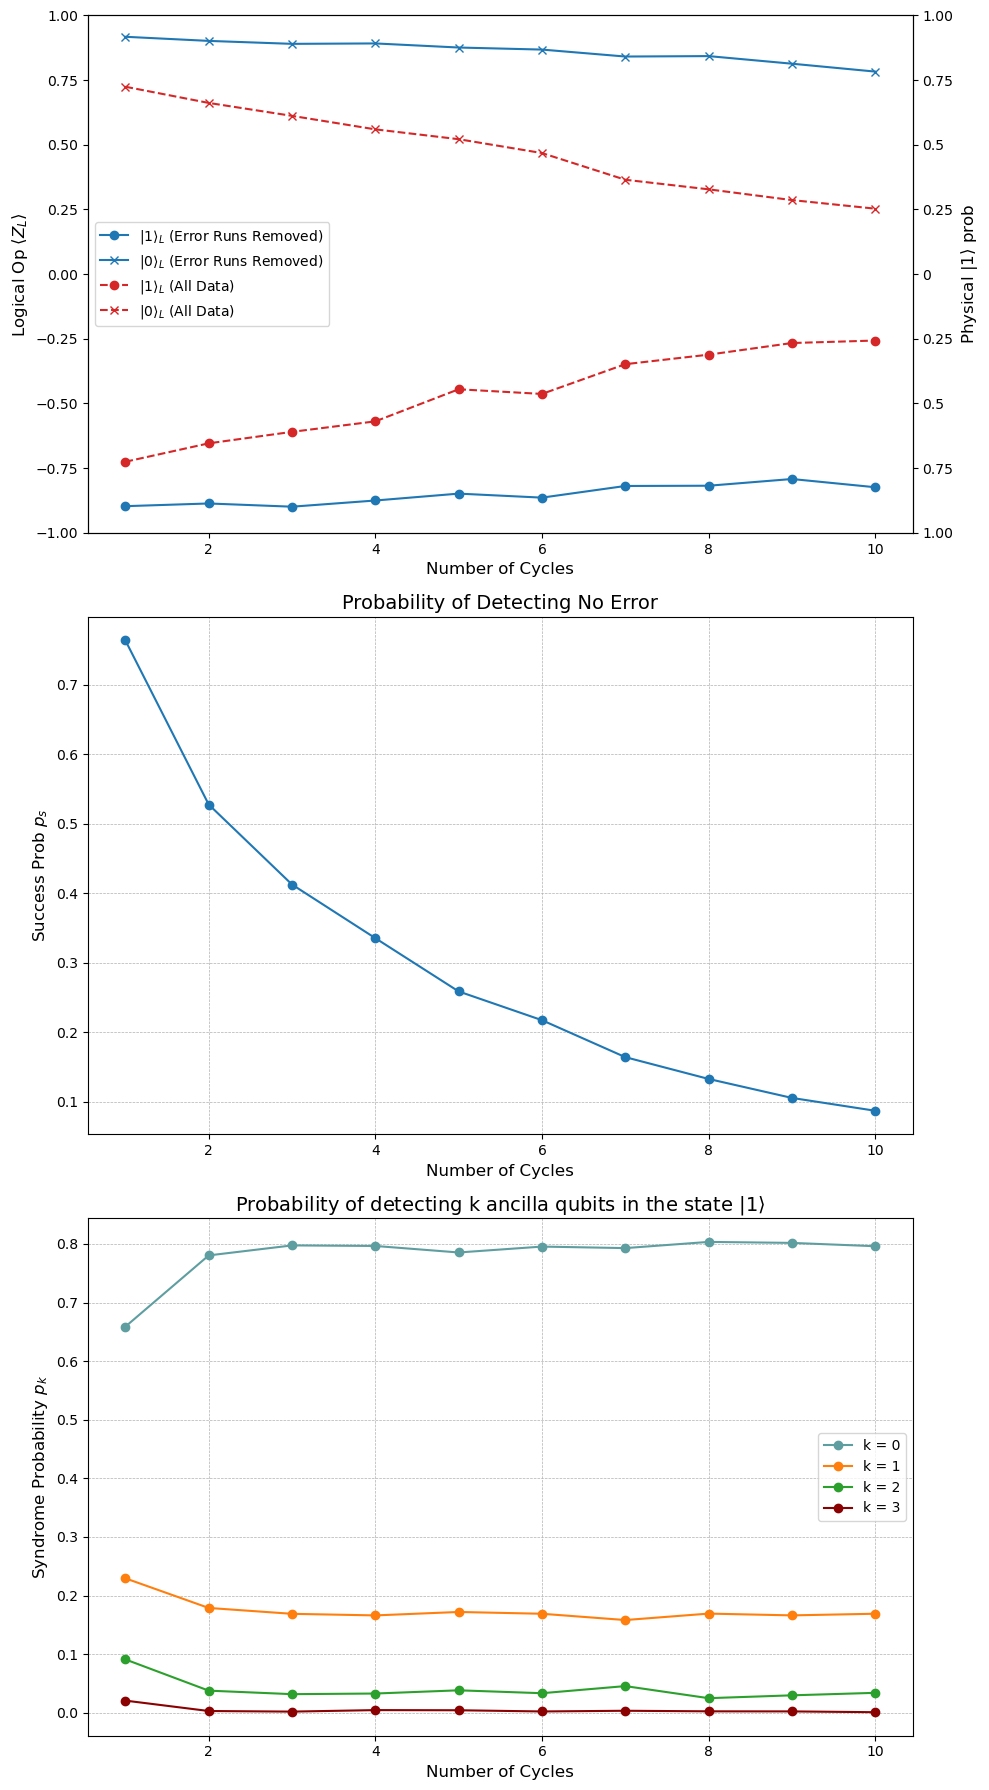

In [17]:
# X axis for all plots
num_cycles = 10
cycles = range(1, num_cycles + 1)

# Define the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))  # 3 rows, 1 column


# First Plot: Logical Operation Expectation Values with Secondary Y-Axis
axs[0].plot(cycles, logical_z_expv_one, color='#1f77b4', linestyle='-', marker='o', label='$|1\\rangle_L$ (Error Runs Removed)')
axs[0].plot(cycles, logical_z_expv_zero, color='#1f77b4', linestyle='-', marker='x', label='$|0\\rangle_L$ (Error Runs Removed)')
axs[0].plot(cycles, logical_z_expv_one_all, color='#d62728', linestyle='--', marker='o', label='$|1\\rangle_L$ (All Data)')
axs[0].plot(cycles, logical_z_expv_zero_all, color='#d62728', linestyle='--', marker='x', label='$|0\\rangle_L$ (All Data)')
axs[0].set_xlabel('Number of Cycles', fontsize=12)
axs[0].set_ylabel('Logical Op $\\langle Z_L \\rangle$', fontsize=12)
axs[0].legend(loc='center left', fontsize=10)
axs[0].set_ylim([-1, 1])

# Creating a secondary y-axis for the first plot
ax2 = axs[0].twinx()
ax2.set_ylabel('Physical $|1\\rangle$ prob', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)
ax2.set_yticks(np.linspace(0, 1, 9))
ax2.set_yticklabels(['1.00', '0.75', '0.5', '0.25', '0', '0.25', '0.5', '0.75', '1.00'])

# Second Plot: Probability of No Error Detection
axs[1].plot(cycles, no_error_probabilities, marker='o', color='#1f77b4')
axs[1].set_xlabel('Number of Cycles', fontsize=12)
axs[1].set_ylabel('Success Prob $p_s$', fontsize=12)
axs[1].set_title('Probability of Detecting No Error', fontsize=14)
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Third Plot: Probability of Detecting k Ancilla Qubits
colors = ['#5f9ea0', '#ff7f0e', '#2ca02c', '#8b0000']
for k, (key, probs) in enumerate(prob_detect_error.items()):
    axs[2].plot(cycles, probs, label=f'k = {key}', color=colors[k % len(colors)], marker='o')
axs[2].set_xlabel('Number of Cycles', fontsize=12)
axs[2].set_ylabel('Syndrome Probability $p_k$', fontsize=12)
axs[2].set_title('Probability of detecting k ancilla qubits in the state $|1\\rangle$', fontsize=14)
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[2].legend(fontsize=10)

# Adjust the layout
plt.tight_layout()

# Show the combined plots
plt.show()
